## Get Data & Run Backtest

***

## Data Wrangling

In [1]:
# Imports
import sqlite3
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

# Connect to sql database
conn = sqlite3.connect("ledger.db")
c = conn.cursor()

In [2]:
# Extract dataframe from the activity log
c.execute("""SELECT * FROM activity_log""")
items_log = c.fetchall()
items_log_df = pd.DataFrame(items_log, columns=["Pair", "Z-Score", "Pair 1 Price", "Pair 1 Price", "Date Time"]).drop("Date Time", axis=1)
items_log_df

,Pair,Z-Score,Pair 1 Price,Pair 1 Price
0,ETHBTC,0.494036,973.21,38437.46
1,ETHBTC,0.269695,973.21,38395.00
2,ETHBTC,-1.006311,977.00,38369.13
3,ETHBTC,-0.077410,971.91,38254.01
4,ETHBTC,-0.217952,971.74,38216.08
...,...,...,...,...
209987,ETHBTC,1.491449,1761.72,24342.11
209988,ETHBTC,1.624191,1761.20,24341.73
209989,ETHBTC,1.583735,1761.12,24342.12
209990,ETHBTC,1.350915,1761.12,24334.23


In [3]:
# Extract trade log into a dataframe
c.execute("""SELECT * FROM tx_ledger WHERE status = 'CLOSED'""")
trade_log = c.fetchall()
trade_log_df = pd.DataFrame(
    trade_log, columns=["Pair", "Type", "Open Date", "Close Date", "Status", "Units 1", "Units 2", "ETH Vol", "BTC Vol", "Pair 1 Open", "Pair 2 Open", "Pair 1 Close", "Pair 2 Close"]).drop(["Open Date", "Close Date"], axis=1)

# Generate profit information and display it
trade_log_df["Profit"] = np.where(
    trade_log_df["Type"] == "Long", 
    trade_log_df["Units 1"] * trade_log_df["Pair 1 Close"] - trade_log_df["Units 1"] * trade_log_df["Pair 1 Open"] + trade_log_df["Units 2"] * trade_log_df["Pair 2 Close"] - trade_log_df["Units 2"] * trade_log_df["Pair 2 Open"], 
    trade_log_df["Units 1"] * trade_log_df["Pair 1 Open"] - trade_log_df["Units 1"] * trade_log_df["Pair 1 Close"] + trade_log_df["Units 2"] * trade_log_df["Pair 2 Open"] - trade_log_df["Units 2"] * trade_log_df["Pair 2 Close"])
trade_log_df["Profit"].sum()

print("Total Profit: ", trade_log_df["Profit"].sum())
print("Winning Trades: ", len(trade_log_df[trade_log_df["Profit"] > 0]))
print("Losing Trades: ", len(trade_log_df[trade_log_df["Profit"] < 0]))
print("Win Rate: ", len(trade_log_df[trade_log_df["Profit"] > 0]) / (len(trade_log_df[trade_log_df["Profit"] > 0]) + len(trade_log_df[trade_log_df["Profit"] < 0])))

Total Profit:  5040.601990000014
Winning Trades:  16633
Losing Trades:  10270
Win Rate:  0.6182581868193139


In [4]:
# Extract dataframe of the pairs from the training CSV, with generated features
pair_info = pd.read_csv("ETH_BTC_train.csv").drop("Unnamed: 0", axis=1)
pair_info = pair_info[:len(items_log_df)]

# Add profit for each trade in the pair_info df from the trade ledger
y = 0
profit_list = []
vol_1_list = []
vol_2_list = []
for x in range(len(pair_info)):
    if pair_info.iloc[x]["Z-Score"] >= 2 or pair_info.iloc[x]["Z-Score"] <= -2:
        if y < len(trade_log_df) - 1:
            profit_list.append(trade_log_df.iloc[y]["Profit"])
            vol_1_list.append(trade_log_df.iloc[y]["ETH Vol"])
            vol_2_list.append(trade_log_df.iloc[y]["BTC Vol"])
            y += 1
        else:
            profit_list.append(0) 
            vol_1_list.append(0)
            vol_2_list.append(0)

    else:
        profit_list.append(0)
        vol_1_list.append(0)
        vol_2_list.append(0)

# Append profit for each line to the dataframe
pair_info["Profit"] = profit_list
pair_info["ETH Vol"] = vol_1_list
pair_info["BTC Vol"] = vol_2_list

print("Profit :", sum(profit_list))
print("Winning Trades: ", len(pair_info[pair_info["Profit"] > 0]))
print("Losing Trades: ", len(pair_info[pair_info["Profit"] < 0]))
print("No Trade: ", len(pair_info[pair_info["Profit"] == 0]))
print("Mean Trade Profit:", pair_info["Profit"].mean())

Profit : 5039.858320000009
Winning Trades:  16632
Losing Trades:  10270
No Trade:  183090
Mean Trade Profit: 0.024000239628176375


In [5]:
# Create profit catagory feature on the pair_info dataframe based on a cut off trade value, no trade is -1, otherwise 1 for a good trade and 0 for a bad trade
pair_info["Profit Catagory"] = -1


pair_info.loc[pair_info["Profit"] >= 1, "Profit Catagory"] = 1 
pair_info.loc[pair_info["Profit"] < -1, "Profit Catagory"] = 0 
pair_info.loc[pair_info["Profit"] == 0, "Profit Catagory"] = -1 

print("Good Trades: ", len(pair_info[pair_info["Profit Catagory"] == 1]))
print("Bad Trades: ", len(pair_info[pair_info["Profit Catagory"] == 0]))
print("No Trades: ", len(pair_info[pair_info["Profit Catagory"] == -1]))
print("Total Trades: ", len(pair_info))

# Filters out the no trade made rows, so the data is only good or bad trades
train_df = pair_info[pair_info["Profit Catagory"] != -1].copy()
train_df

Good Trades:  13660
Bad Trades:  8209
No Trades:  188123
Total Trades:  209992


,ETH Close,ETH Volume,ETH Close_1,ETH Close_2,ETH Close_3,ETH Close_4,ETH Close_5,ETH Close_6,ETH Close_7,ETH Close_8,...,Coint Spread,Mean,STD,Z-Score,Z-Score Lag 1,Z-Score Lag 2,Profit,ETH Vol,BTC Vol,Profit Catagory
26,963.91,4.69254,6.878223,6.878223,6.880446,6.880446,6.878162,6.875294,6.877296,6.878182,...,1.306814,1.299882,0.002776,2.497397,0.449780,0.156539,1.50780,4.69254,0.144928,1
27,964.00,0.84276,6.870998,6.878223,6.878223,6.880446,6.880446,6.878162,6.875294,6.877296,...,1.307353,1.299983,0.002952,2.496872,2.497397,0.449780,1.30753,0.84276,0.929672,1
46,961.66,18.61801,6.871091,6.871091,6.871091,6.871091,6.871091,6.871091,6.869389,6.870842,...,1.309377,1.303064,0.003073,2.054796,1.438472,1.611274,2.24816,18.61801,0.060924,1
47,960.00,7.81272,6.868661,6.871091,6.871091,6.871091,6.871091,6.871091,6.871091,6.869389,...,1.309816,1.303295,0.003137,2.078713,2.054796,1.438472,3.18082,7.81272,0.600621,1
48,958.00,5.89768,6.866933,6.868661,6.871091,6.871091,6.871091,6.871091,6.871091,6.871091,...,1.311489,1.303498,0.003330,2.399248,2.078713,2.054796,4.00839,5.89768,0.438077,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209344,1768.00,0.00580,7.478498,7.478701,7.478102,7.478351,7.477864,7.480124,7.480671,7.481764,...,0.052558,0.047762,0.002249,2.132015,1.787492,1.844933,1.27358,0.00580,0.496300,1
209345,1767.11,0.16880,7.477604,7.478498,7.478701,7.478102,7.478351,7.477864,7.480124,7.480671,...,0.052819,0.047891,0.002351,2.096239,2.132015,1.787492,1.50127,0.16880,0.071360,1
209877,1775.04,10.54510,7.478401,7.477604,7.477644,7.476557,7.476076,7.476246,7.475923,7.476223,...,0.044000,0.049993,0.001375,-4.359243,-2.197493,-2.147353,1.80632,10.54510,0.864540,1
209878,1771.69,7.47080,7.481578,7.478401,7.477604,7.477644,7.476557,7.476076,7.476246,7.475923,...,0.046008,0.049885,0.001470,-2.637554,-4.359243,-2.197493,1.20367,7.47080,0.096710,1


In [8]:
# Set price of each instrument as the log of the price to scale the data
train_df["ETH Vol"] = np.log(pair_info["ETH Vol"] + 0.001)
train_df["BTC Vol"] = np.log(pair_info["BTC Vol"] + 0.001)

In [9]:
# Reindex the df to what is expected by model
train_df = train_df.reindex(['ETH Close', 'BTC Close', 'Coint Spread', 'Mean', 'STD', 'Z-Score', 'ETH Vol', 'BTC Vol', 'Z-Score Lag 1', 'Z-Score Lag 2',
                         'ETH Close_1', 'ETH Close_2', 'ETH Close_3', 'ETH Close_4',
                         'ETH Close_5', 'ETH Close_6', 'ETH Close_7', 'ETH Close_8',
                         'ETH Close_9', 'ETH Close_10', 'ETH Close_11', 'ETH Close_12',
                         'ETH Close_13', 'ETH Close_14', 'ETH Close_15', 'ETH Close_16',
                         'ETH Close_17', 'ETH Close_18', 'ETH Close_19', 'ETH Close_20',
                         'ETH Close_21', 'ETH Close_22', 'ETH Close_23', 'ETH Close_24',
                         'ETH Close_25', 'ETH Close_26', 'ETH Close_27', 'ETH Close_28',
                         'ETH Close_29', 'ETH Close_30', 'BTC Close_1',
                         'BTC Close_2', 'BTC Close_3', 'BTC Close_4', 'BTC Close_5',
                         'BTC Close_6', 'BTC Close_7', 'BTC Close_8', 'BTC Close_9',
                         'BTC Close_10', 'BTC Close_11', 'BTC Close_12', 'BTC Close_13',
                         'BTC Close_14', 'BTC Close_15', 'BTC Close_16', 'BTC Close_17',
                         'BTC Close_18', 'BTC Close_19', 'BTC Close_20', 'BTC Close_21',
                         'BTC Close_22', 'BTC Close_23', 'BTC Close_24', 'BTC Close_25',
                         'BTC Close_26', 'BTC Close_27', 'BTC Close_28', 'BTC Close_29',
                         'BTC Close_30', 'Profit', 'Profit Catagory', 'Beta'], axis=1)

train_df

,ETH Close,BTC Close,Coint Spread,Mean,STD,Z-Score,ETH Vol,BTC Vol,Z-Score Lag 1,Z-Score Lag 2,...,BTC Close_24,BTC Close_25,BTC Close_26,BTC Close_27,BTC Close_28,BTC Close_29,BTC Close_30,Profit,Profit Catagory,Beta
26,6.870998,10.546656,1.306814,1.299882,0.002776,2.497397,1.546187,-1.924642,0.449780,0.156539,...,10.555009,10.555683,10.556788,10.554195,10.554100,10.554210,10.553516,1.50780,1,1.34476
27,6.871091,10.547321,1.307353,1.299983,0.002952,2.496872,-0.169887,-0.071848,2.497397,0.449780,...,10.552004,10.555009,10.555683,10.556788,10.554195,10.554100,10.554210,1.30753,1,1.34476
46,6.868661,10.546077,1.309377,1.303064,0.003073,2.054796,2.924183,-2.781847,1.438472,1.611274,...,10.552251,10.552689,10.548955,10.548915,10.551529,10.551582,10.551393,2.24816,1,1.34476
47,6.866933,10.544193,1.309816,1.303295,0.003137,2.078713,2.055881,-0.508128,2.054796,1.438472,...,10.551757,10.552251,10.552689,10.548955,10.548915,10.551529,10.551582,3.18082,1,1.34476
48,6.864848,10.543060,1.311489,1.303498,0.003330,2.399248,1.774729,-0.823080,2.078713,2.054796,...,10.549702,10.551757,10.552251,10.552689,10.548955,10.548915,10.551529,4.00839,1,1.34476
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209344,7.477604,10.108140,0.052558,0.047762,0.002249,2.132015,-4.990833,-0.698562,1.787492,1.844933,...,10.110468,10.110514,10.110446,10.111245,10.112458,10.112346,10.111845,1.27358,1,1.34476
209345,7.477101,10.107724,0.052819,0.047891,0.002351,2.096239,-1.773134,-2.626102,2.132015,1.787492,...,10.110590,10.110468,10.110514,10.110446,10.111245,10.112458,10.112346,1.50127,1,1.34476
209877,7.481578,10.104926,0.044000,0.049993,0.001375,-4.359243,2.355756,-0.144402,-2.197493,-2.147353,...,10.101472,10.100765,10.101038,10.101023,10.100359,10.100118,10.100436,1.80632,1,1.34476
209878,7.479689,10.104394,0.046008,0.049885,0.001470,-2.637554,2.011136,-2.325751,-4.359243,-2.197493,...,10.101276,10.101472,10.100765,10.101038,10.101023,10.100359,10.100118,1.20367,1,1.34476


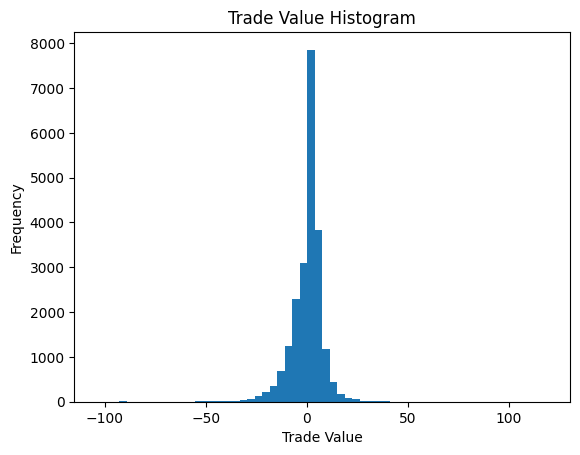

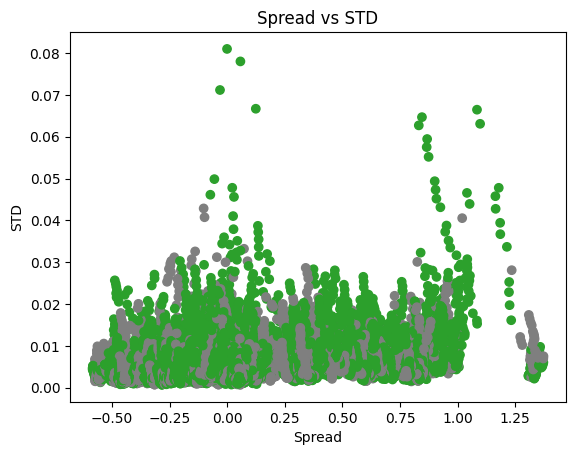

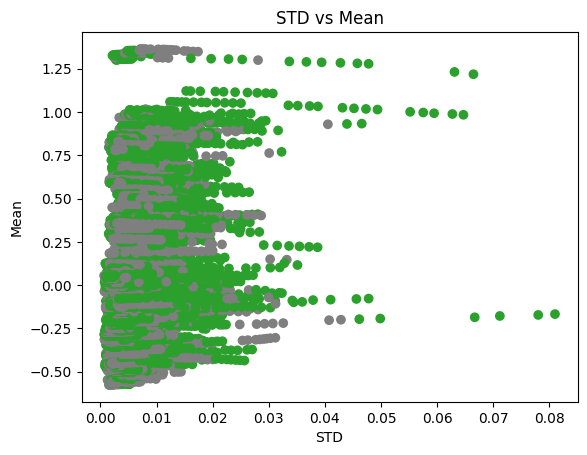

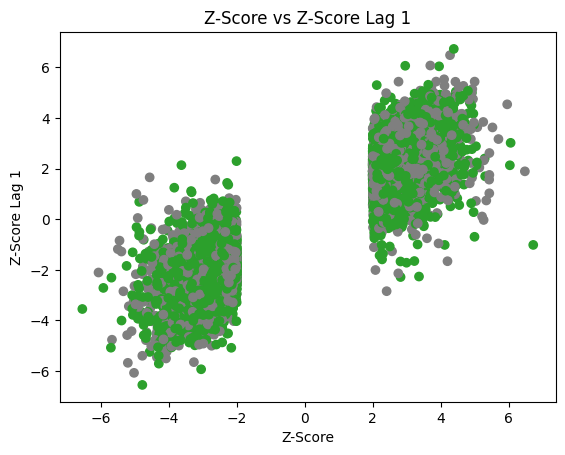

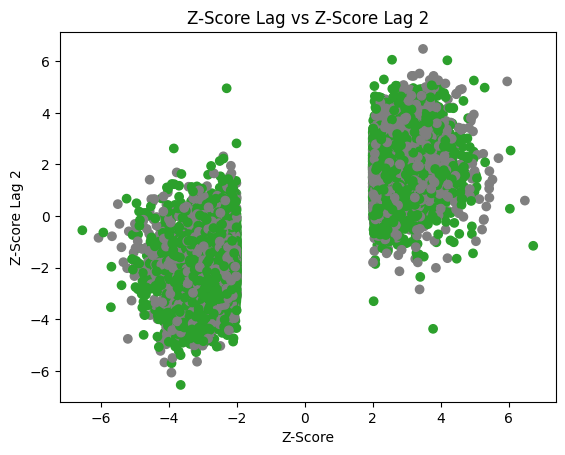

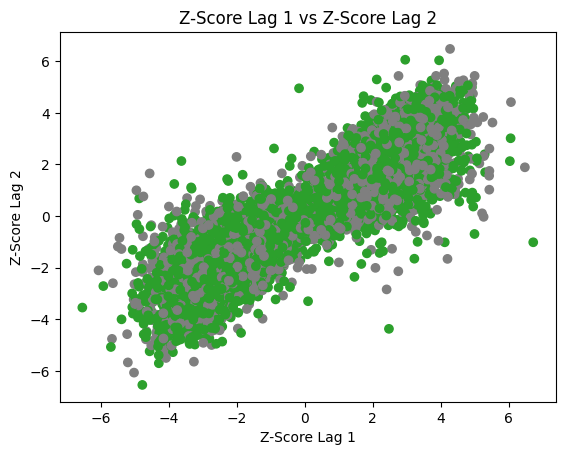

In [10]:
# Display the trade profit catagory information
import matplotlib.pyplot as plt


plt.hist(train_df["Profit"], bins=60)
plt.title("Trade Value Histogram")
plt.xlabel("Trade Value")
plt.ylabel("Frequency")
plt.show()

colors = {1:'tab:green', 0: 'tab:grey'}

plt.scatter(train_df["Coint Spread"], train_df["STD"], c=train_df["Profit Catagory"].map(colors))
plt.title("Spread vs STD")
plt.xlabel("Spread")
plt.ylabel("STD")
plt.show()

plt.scatter(train_df["STD"], train_df["Mean"], c=train_df["Profit Catagory"].map(colors))
plt.title("STD vs Mean")
plt.xlabel("STD")
plt.ylabel("Mean")
plt.show()

plt.scatter(train_df["Z-Score"], train_df["Z-Score Lag 1"], c=train_df["Profit Catagory"].map(colors))
plt.title("Z-Score vs Z-Score Lag 1")
plt.xlabel("Z-Score")
plt.ylabel("Z-Score Lag 1")
plt.show()

plt.scatter(train_df["Z-Score"], train_df["Z-Score Lag 2"], c=train_df["Profit Catagory"].map(colors))
plt.title("Z-Score Lag vs Z-Score Lag 2")
plt.xlabel("Z-Score")
plt.ylabel("Z-Score Lag 2")
plt.show()

plt.scatter(train_df["Z-Score Lag 1"], train_df["Z-Score Lag 2"], c=train_df["Profit Catagory"].map(colors))
plt.title("Z-Score Lag 1 vs Z-Score Lag 2")
plt.xlabel("Z-Score Lag 1")
plt.ylabel("Z-Score Lag 2")
plt.show()

***
## XGBoost Moodel

In [11]:
# Train test split
from sklearn.model_selection import train_test_split

y_data = train_df["Profit Catagory"].copy()
x_data = train_df.copy()
x_data = x_data.drop(["Profit Catagory", "Profit", "Beta", "Z-Score"], axis=1)

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.1)
print("Training rows: ", len(y_train[y_train == 1]))
print("Testing rows: ",len(y_test[y_test == 1]))

x_train = x_train.values
x_test = x_test.values
y_train = y_train.values
y_test = y_test.values

Training rows:  12321
Testing rows:  1339


In [12]:
# Train model and save it
from xgboost import XGBClassifier

model = XGBClassifier(eval_metric="error", n_estimators=100, early_stopping_rounds=10)
model.fit(x_train, y_train, eval_set=[(x_test, y_test)], verbose=False)
model.save_model("eth_btc.model")

# Test model
from sklearn.metrics import accuracy_score
y_pred = model.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print("Model Accuracy: ", accuracy)

Model Accuracy:  0.8084133516232281
